In [1]:
# imports
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [2]:
# get dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)

X = data.images.reshape(data.images.shape[0], -1)
y = data.target

print("Images shape:", X.shape)
print("Labels shape:", y.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Images shape: (400, 4096)
Labels shape: (400,)


In [3]:
# split data into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 320
Test set size: 80


In [4]:
# create and fit the pca instance / transform data
pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
X_train_reduced[0].shape

(221,)

In [5]:
# find best covariance type
covariance_types = ["full", "tied", "diag", "spherical"]

# dictionaries to store scores
scores_by_cov_type = {cov_type: [] for cov_type in covariance_types}

best_covariance_type = None
best_n_comp = None
best_score = np.inf  # initialize with a high value

# gridsearch covariance type and number of clusters
for n in tqdm(range(1, 201, 5)):
  for cov_type in covariance_types:
      gmm = GaussianMixture(n_components=n, covariance_type=cov_type, reg_covar=1e-05)
      gmm.fit(X_train_reduced)
      score = gmm.bic(X_train_reduced)

      scores_by_cov_type[cov_type].append((n, score))

      # override if better score
      if score < best_score:
          best_score = score
          best_n_comp = n
          best_covariance_type = cov_type

print("\nBest number of components: ", best_n_comp)
print("Best covariance type: ", best_covariance_type)

100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


Best number of components:  196
Best covariance type:  spherical


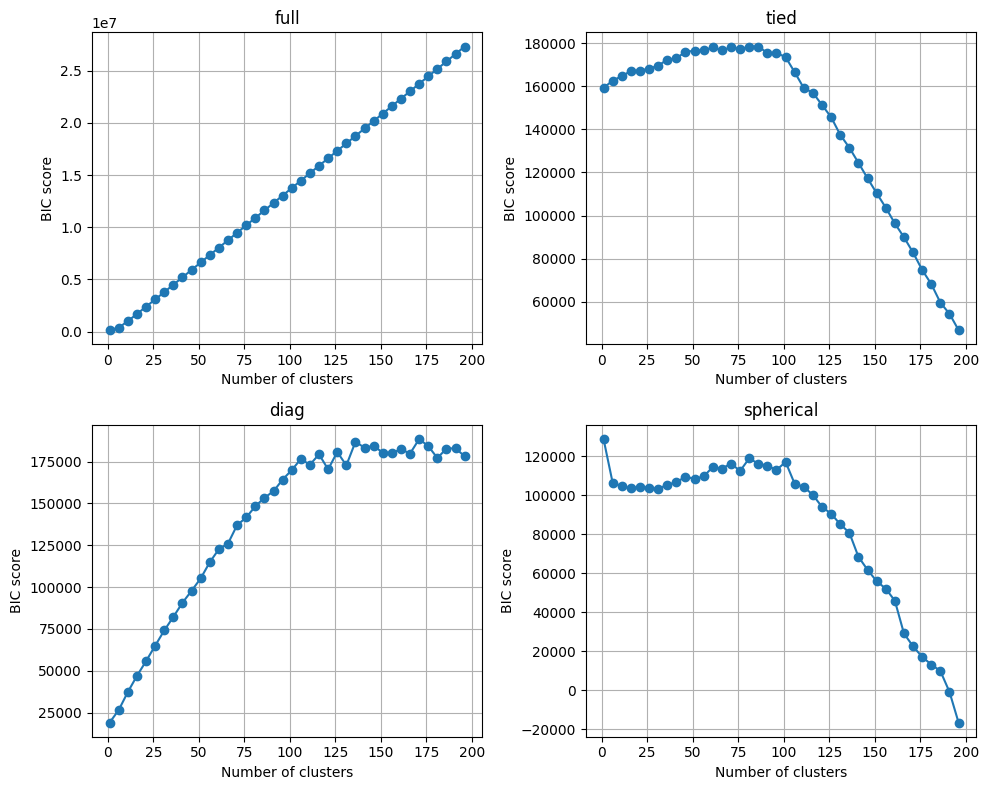

In [6]:
# plot scores of gridsearch
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, cov_type in enumerate(covariance_types):
    scores = scores_by_cov_type[cov_type]
    n_clusters, bic_scores = zip(*scores)

    row = i // 2
    col = i % 2
    ax = axs[row, col]

    ax.plot(n_clusters, bic_scores, marker="o")
    ax.set_title(cov_type)
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("BIC score")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# create model with best params
gmm = GaussianMixture(n_components=best_n_comp, covariance_type=best_covariance_type, reg_covar=1e-05)
gmm.fit(X_train_reduced)

GaussianMixture(covariance_type='spherical', n_components=196, reg_covar=1e-05)

In [8]:
# predict and print hard clustering
hard_cluster_assignments = gmm.predict(X_test_reduced)
print("Hard clustering for each instance:")
print(hard_cluster_assignments)

Hard clustering for each instance:
[117  20 164  18  18 166  39  35  71  54  62  41  18 103  42  20  32  71
  62 119  19  47 108 161   2 164  19  71  14 108  19   2  19 162  63  98
 101  29  18  19   0  50  18  18 108  44  29  20   5  71  18  18  18 190
  63  28   8  49  19  44  64   4 103 101  83  34  12  55  43 130 105  71
  42   5  19  52  20  19  71   4]


In [9]:
# predict and print soft clustering
soft_cluster_probabilities = gmm.predict_proba(X_test_reduced)
print("Soft clustering for each instance:")
print(soft_cluster_probabilities)

Soft clustering for each instance:
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.36432468e-306 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.83847255e-319 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [31]:
# sample new faces with gmm
num_faces_to_generate = 5
generated_samples = gmm.sample(n_samples=num_faces_to_generate)
generated_faces = pca.inverse_transform(generated_samples[0])
generated_faces.shape

(5, 4096)

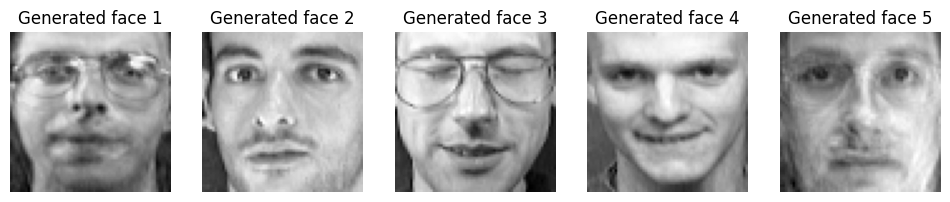

In [32]:
# visualize generated faces
generated_faces = generated_faces.reshape(num_faces_to_generate, 64, 64)

fig, axes = plt.subplots(1, num_faces_to_generate, figsize=(12, 4))
for i in range(num_faces_to_generate):
    axes[i].imshow(generated_faces[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Generated face {i + 1}")

plt.show()

In [33]:
# get random normal faces
num_normal_images = 5
random_indices = random.sample(range(X_test.shape[0]), num_normal_images)
normale_faces = [X_test[i].reshape(64, 64) for i in random_indices]

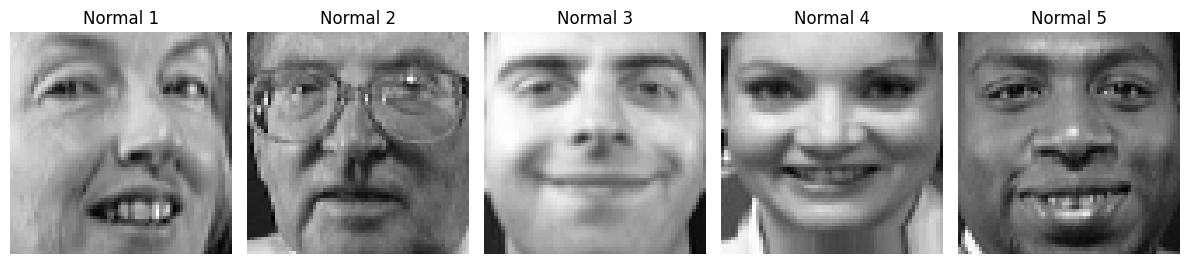

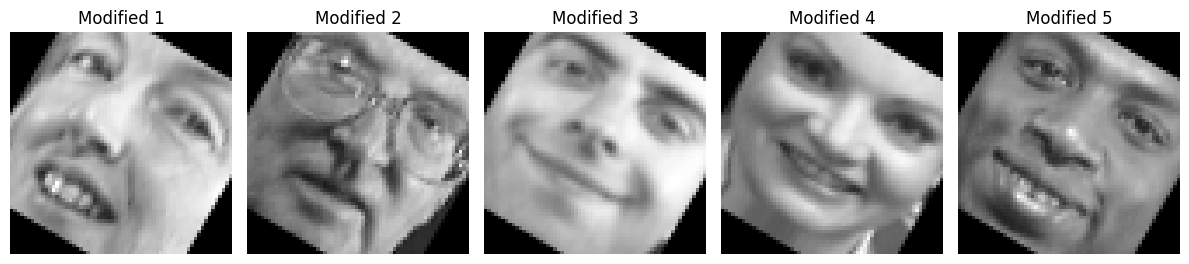

In [34]:
# visualize normal faces
fig, axes = plt.subplots(1, num_normal_images, figsize=(12, 4))
for i in range(num_normal_images):
    axes[i].imshow(normale_faces[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Normal {i + 1}")

plt.tight_layout()
plt.show()

modified_faces = []

# modify and visualize faces
fig, axes = plt.subplots(1, num_normal_images, figsize=(12, 4))
for i in range(num_normal_images):
    # rotate image
    rotated_face = cv2.warpAffine(normale_faces[i], cv2.getRotationMatrix2D((32, 32), 30, 1.0), (64, 64))

    # flip image
    flipped_face = cv2.flip(rotated_face, 1)

    modified_faces.append(flipped_face)

    axes[i].imshow(flipped_face, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Modified {i + 1}")

plt.tight_layout()
plt.show()

In [35]:
# calculate sample scores
normal_faces_pca = pca.transform([face.reshape(-1) for face in normale_faces])
modified_faces_pca = pca.transform([face.reshape(-1) for face in modified_faces])

normal_scores = gmm.score_samples(normal_faces_pca)
anomalous_scores = gmm.score_samples(modified_faces_pca)

threshold = normal_scores.mean() - 2 * normal_scores.std()

# identify anomalies
anomalies = [i for i, score in enumerate(anomalous_scores) if score < threshold]

print("Anomalies Detected:", anomalies)

Anomalies Detected: [0, 1, 2, 3, 4]


In [36]:
normal_scores.mean()

-432.79459164352284

In [37]:
anomalous_scores.mean()

-1611.3288679212635